# Assignment — Link Prediction

In [1]:
!pip install gensim==4.0.0 -q

     |████████████████████████████████| 23.9MB 51.9MB/s 


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
import requests
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content);


### Task 1. Similarity based link prediction (0 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [6]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df.head()

,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [19]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    
    email_temp = email_df.copy()
    email_temp = email_temp[
        (train_period[0] <= email_temp.timestamp) 
        & (email_temp.timestamp < test_period[1])
    ]
    email_temp['from'] = email_temp[['sender', 'receiver']].min(axis=1)
    email_temp['to'] = email_temp[['sender', 'receiver']].max(axis=1)
    email_temp = email_temp.drop(['sender', 'receiver'], axis=1)
    email_temp = email_temp.set_index(['from', 'to'])

    email_train = email_temp[email_temp.timestamp < train_period[1]]
    email_train = email_train.groupby(['from', 'to']).count()
    train_core = email_train[email_train.timestamp >= ktrain].index.tolist()

    email_test = email_temp[test_period[0] <= email_temp.timestamp]
    email_test = email_test.groupby(['from', 'to']).count()
    test_core = email_test[email_test.timestamp >= ktest].index.tolist()
    
    core = list(set(train_core + test_core))

    # YOUR CODE HERE
    email_first = email_temp.loc[core].groupby(['from', 'to']).min()

    train_edges = email_first[email_first.timestamp < train_period[1]].index.tolist()
    test_edges = email_first[test_period[0] <= email_first.timestamp].index.tolist()
    
    return train_edges, test_edges
    raise NotImplementedError()

In [20]:
train_edges, test_edges = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 3, 3)
_train_edges, _test_edges = np.array(train_edges), np.array(test_edges)
assert np.all(_train_edges[:, 0] < _train_edges[:, 1])
assert np.all(_test_edges[:, 0] < _test_edges[:, 1])
assert len(set(train_edges).intersection(test_edges)) == 0
assert _train_edges.shape == (4147, 2)
assert _test_edges.shape == (418, 2)

The similarity based algorithm:
1. Compute similarity matrix for all pairs of nodes except $E_\text{train}$
2. Order that pairs in descending of similarity
3. Select some threshold and predict links for all pairs above the threshold

Write a function `sim_link_prediction` that takes a list with train edges and test edges. The function predicts links and returns a tuple with metrics: 
* two np.arrays: FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`
* the same, by Adamic/Adar index, `nx.adamic_adar_index`
* the same, by resource allocation index, `nx.resource_allocation_index`

_Hint: use `sklearn.metrics.roc_curve`._

In [21]:
def sim_link_prediction(train_edges, test_edges):
    
    nodes = sorted(set(np.array(train_edges + test_edges).flatten()))
    train_edges = set(train_edges)
    test_edges = set(test_edges)
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(train_edges)
    
    # YOUR CODE HERE
    y_true = []
    edges_to_rate = []
    
    for node_i in nodes:
        for node_j in nodes:
            if node_i >= node_j:
                continue
            if (node_i, node_j) in train_edges:
                continue
            y_true.append((node_i, node_j) in test_edges)
            edges_to_rate.append((node_i, node_j))
    
    res = []
    for index in tqdm([nx.jaccard_coefficient, 
                       nx.adamic_adar_index, 
                       nx.resource_allocation_index]):
        y_score = [p for u, v, p in tqdm(index(G, edges_to_rate), 
                                         total=len(edges_to_rate), 
                                         leave=False)]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        res.append((fpr, tpr))
    
    return res
    raise NotImplementedError()

In [22]:
jac, adam, res = sim_link_prediction(train_edges, test_edges)

In [25]:
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 0.8371
assert round(auc(adam[0], adam[1]), 4) == 0.8500
assert round(auc(res[0], res[1]), 4) == 0.8495

Let us look at ROC AUC curve to compare similaritites.

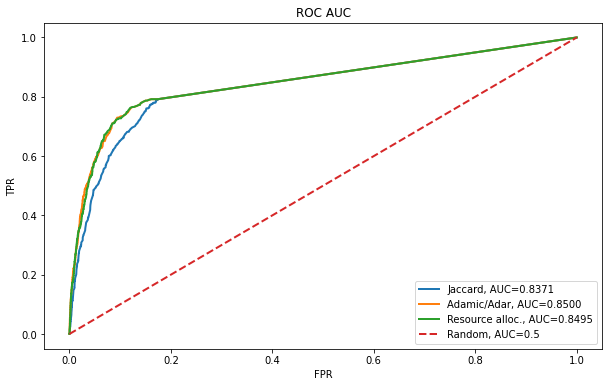

In [26]:
plt.figure(figsize=(10, 6))
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic/Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 2. SVD node embeddings (0 points)

Similarly to the node classification task, node embeddings could be helpful in the link prediction problem. The simplest way to obtain embeddings is to decompose some graph representation. However, in the given task, it could be helpful to factorize proximity matrices.

Usually, graphs are sparse, so there is a high imbalance between positive (edge exists) and negative classes.
To eliminate this problem, we can use the undersampling technique. 

The `negative_sampling` function should sample the unexisted edges from our graph, so they are the most similar by the number of common neighbors. The result is the list of tuples with pairs of nodes (similar to the `train_edges`) in descending similarity score.

In [29]:
def negative_sampling(train_edges, test_edges):
    # YOUR CODE HERE
    G = nx.Graph()
    G.add_nodes_from(range(np.max(train_edges + test_edges) + 1))
    G.add_edges_from(train_edges + test_edges)
    A = nx.to_numpy_array(G)
    sim = A @ A
    sim = sim * (1 - A)
    sim[range(A.shape[0]), range(A.shape[0])] = 0
    sorting = np.argsort(sim[sim > 0])[::-1]
    sample = np.argwhere(sim > 0)[sorting][:len(test_edges)*2:2]
    return [(i, j) for i, j in sample]
    raise NotImplementedError()

In [30]:
negatives = negative_sampling(train_edges, test_edges)
assert len(negatives) == len(test_edges)
assert len(set(negatives) & set(test_edges)) == 0
assert negatives[0] == (90, 159)

np.random.seed(0)
validation = np.array(negatives + test_edges)[np.random.permutation(len(negatives) * 2)]
y_true = [int(tuple(i) in test_edges) for i in validation]

Here we obtain node embeddings via Truncated SVD of adjacency matrix of train edges.

In [31]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_edges + test_edges) + 1))
G.add_edges_from(train_edges)
A = nx.to_numpy_array(G)
embeddings = TruncatedSVD(n_components=4).fit_transform(A)
embeddings.round(2)

array([[ 0.83, -0.92, -0.5 ,  2.35],
       [ 0.05,  0.  , -0.04, -0.03],
       [ 2.04,  0.85,  0.22,  0.73],
       ...,
       [ 0.01, -0.  , -0.01,  0.  ],
       [ 0.14, -0.04, -0.11, -0.08],
       [ 0.47, -0.46, -0.5 ,  1.39]])

Here you need to define `inner_product_decoder` function. It takes an array with node embeddings and a list of pairs of nodes. It should return np.array with the recovered score calculated by the dot product of embeddings for pairs of nodes `pairs`.

$$e_{ij} = \langle n_i, n_j\rangle$$

In [32]:
def dot_product_decoder(embeddings, pairs):
    # YOUR CODE HERE
    edges = np.array(pairs)
    return (embeddings[edges[:, 0]] * embeddings[edges[:, 1]]).sum(axis=1)
    raise NotImplementedError()

In [33]:
scores = dot_product_decoder(embeddings, validation)
tpr, fpr, _ = roc_curve(y_true, scores)
assert auc(fpr, tpr) > 0.9

### Task 3. Edge embeddings (6 points)

In the previous task, we train node level embeddings. However, for LPP, we need to have edge representation and decide whether to connect incident nodes or not.

You will need to compare several techniques of edge embedding calculation from the [paper](https://peerj.com/articles/cs-172/#table-2).

Compare the different vector aggregations as features for `sklearn.linear_model.LogisticRegression` with default hyperparameters.

All following functions should return np.array with embeddings of edges from edges param.

Average operator is simple elementwise average of node embeddings

In [36]:
def average_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return 0.5 * (embeddings[edges[:, 0]] + embeddings[edges[:, 1]])
    raise NotImplementedError()

In [37]:
G_train = nx.Graph()
G_train.add_nodes_from(range(np.max(train_edges + test_edges) + 1))
G_train.add_edges_from(train_edges)

assert round(average_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 2.0119

Hadamard product is an elementwise product of node embeddings

In [38]:
def hadamard_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return embeddings[edges[:, 0]] * embeddings[edges[:, 1]]
    raise NotImplementedError()

In [39]:
assert round(hadamard_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 3.67

Weighted L1 is a absolute of elementwise difference between node embeddings

In [40]:
def weighted_l1_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return np.absolute(embeddings[edges[:, 0]] - embeddings[edges[:, 1]])
    raise NotImplementedError()

In [41]:
assert round(weighted_l1_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 1.2295

Weighted L2 is a square of elementwise difference between node embeddings

In [42]:
def weighted_l2_operator(G, embeddings, edges):
    # YOUR CODE HERE
    return (embeddings[edges[:, 0]] - embeddings[edges[:, 1]])**2
    raise NotImplementedError()

In [44]:
assert round(weighted_l2_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 1.5116

Neighbor weighted L1 is a absolute of elementwise difference between mean embeddings of node neigbors with itself

In [45]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    # YOUR CODE HERE
    result = np.zeros((edges.shape[0], embeddings.shape[1]))
    for k, (n1, n2) in enumerate(edges):

        Vector1 = np.array([embeddings[node] for node in G_train.neighbors(edges[:, 0][k])])
        Vector2 = np.array([embeddings[node] for node in G_train.neighbors(edges[:, 1][k])])
        
        emb_sum1 = (embeddings[edges[:, 0][k]] + Vector1.sum(axis=0)) / (len(Vector1) + 1)
        emb_sum2 = (embeddings[edges[:, 1][k]] + Vector2.sum(axis=0)) / (len(Vector2) + 1)
        
        result[k] = (emb_sum1 - emb_sum2)
    return np.absolute(result)
    raise NotImplementedError()

In [46]:
assert round(neighbor_weighted_l1_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.7193

Neighbor weighted L1 is a square of elementwise difference between mean embeddings of node neigbors with itself

In [47]:
def neighbor_weighted_l2_operator(G, embeddings, edges):
    # YOUR CODE HERE
    result = np.zeros((edges.shape[0], embeddings.shape[1]))
    for k, (n1, n2) in enumerate(edges):

        Vector1 = np.array([embeddings[node] for node in G_train.neighbors(edges[:, 0][k])])
        Vector2 = np.array([embeddings[node] for node in G_train.neighbors(edges[:, 1][k])])
        
        emb_sum1 = (embeddings[edges[:, 0][k]] + Vector1.sum(axis=0)) / (len(Vector1) + 1)
        emb_sum2 = (embeddings[edges[:, 1][k]] + Vector2.sum(axis=0)) / (len(Vector2) + 1)
        
        result[k] = (emb_sum1 - emb_sum2)
    return result**2
    raise NotImplementedError()

In [48]:
assert round(neighbor_weighted_l2_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.5174

In [49]:
from sklearn.linear_model import LogisticRegression

operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(validation) * 0.8)
res = {}
for nm, f in operators.items():
    lr = LogisticRegression()
    e = f(G_train, embeddings, validation)
    lr.fit(e[:train_split], y_true[:train_split])
    preds = lr.predict_proba(e[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[nm] = {
        'fpr': fpr,
        'tpr': tpr
    }

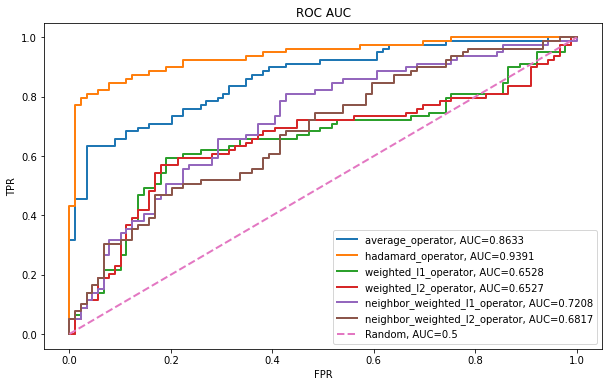

In [50]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 4. Walklets (4 points)

Walklets (Perozzi, Kulkarni & Skiena, 2016) use a weighted combination of embeddings of powers of adjacency matrix $A$, $A^2$, …, $A^k$ to reduce the bias of Deepwalk for low-order proximities, and approximates computing $A^i$ by skipping nodes using short random walks (Perozzi et al., 2017).

The general idea is that we need to catch global graph level information for the link prediction task, not only local neighbourhood like in case with DeepWalks.

Firstly, we need to sample some random walks. You can take this function from the last task of the node classification assignment.

In [53]:
def random_walks(G, n_walks, path_length):
    # YOUR CODE HERE
    def one_random_walk(G, node_start, path_length):
        node = node_start
        path = [node]
        while len(path) < path_length:
            node = np.random.choice(list(G.neighbors(node)))
            path.append(node)
        return path
    random_walks = []
    for node in G.nodes:
        random_walks.extend([one_random_walk(G, node, path_length) for _ in range(n_walks)])
    return np.array(random_walks)
    raise NotImplementedError()

In [54]:
G = nx.karate_club_graph()
walks = random_walks(G, 10, 5)

assert walks.shape == (34*10, 5)
for i, j in zip(walks[0, :-1], walks[0, 1:]):
    assert G.has_edge(i, j)
assert np.all(walks[:, 0] == np.repeat(np.arange(34), 10))

When we have random walks, we can add skips to them. Function `make_skips` separates a random walk `walk` on the several walks with steps between each `node` equal to the `length`. It returns list of lists with random walks with skips steps, look at asserts.

In [55]:
def make_skips(walk, length):
    # YOUR CODE HERE
    result = []
    for i in range(len(walk)):
        temp = list(np.array(walk)[np.arange(i, len(walk), length)])
        result.append(temp)
        if temp == result[0][1:]:
            break
    return result
    raise NotImplementedError()

In [56]:
walk = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
assert make_skips(walk, 2) == [[0, 2, 4, 6, 8], [1, 3, 5, 7, 9], [2, 4, 6, 8]]
assert make_skips(walk, 3) == [[0, 3, 6, 9], [1, 4, 7], [2, 5, 8], [3, 6, 9]]

skipped = make_skips(walks[0], 2)
assert len(skipped) == 3
assert len(skipped[1]) == 2

Now, you need to define the function that will extract random walks with skips from the list of random walks and return another list of random walks, but with skips

In [57]:
def make_skips_dataset(input_walks, length):
    # YOUR CODE HERE
    result = []
    for walk in input_walks:
        result.extend([el for el in make_skips(walk, length)])
    return result
    raise NotImplementedError()

In [58]:
example_walks = [[0, 2, 4, 6, 8], [1, 3, 5, 7, 9], [2, 4, 6, 8]]
assert (
    make_skips_dataset(example_walks, 2) == 
    [[0, 4, 8], [2, 6], [4, 8], [1, 5, 9], [3, 7], [5, 9], [2, 6], [4, 8], [6]]
)

skipped = make_skips_dataset(walks, 2)
assert len(skipped) == 1020
assert len(skipped[1]) == 2

To train embedding you need to know the set of nodes, sampled random walks without skips, size of the maximal desired skip (window_size) and dimension of embedding for the one skip.

The function `train_embedding` should work as follows:
For each skip_length between `1` and `window_size + 1`
1. Create dataset with splits
2. Train Word2Vec model on the created dataset with given vector_size, min_count=1, sg=1 and window=1.
3. save embeddings for the given step

After all iterations you need to take a mean of received embeddings for a node from each step. Finally, we return np.array with embeddings ordered by the id of node, if node id has no embedding, then use `np.zeros(vector_size)`

In [114]:
def train_embedding(nodes, walks, window_size=5, vector_size=8):
    # YOUR CODE HERE
    data = np.zeros((len(nodes), vector_size))
    emb = []
    for i, skip_length in enumerate(range(1, window_size + 1)):
        current_data = make_skips_dataset(walks, skip_length)
        current_data = [[str(el) for el in sub_list] for sub_list in make_skips_dataset(walks, 2)]
        model = Word2Vec(vector_size=vector_size, window=1, min_count=1, sg=1)
        model.build_vocab(current_data)
        model.train(current_data, total_examples=len(current_data), epochs=200)
        emb.append(model.wv)
    for node in nodes:
        if str(node) in emb[0].index_to_key:
            
            data[node] = np.array([emb[k][str(node)] for k in range(5)]).sum(axis=0) / 5
        else:
            data[node] = np.zeros((vector_size))
    return data
    raise NotImplementedError()

In [115]:
np.random.seed(0)
G = nx.Graph(train_edges)
nodes = np.arange(np.max(train_edges + test_edges) + 1)
walks = random_walks(G, 10, 5)
embeddings = train_embedding(nodes, walks)
assert embeddings.shape == (1005, 8)

In [116]:
operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(validation) * 0.8)
res = {}
for nm, f in operators.items():
    lr = LogisticRegression()
    e = f(G_train, embeddings, validation)
    lr.fit(e[:train_split], y_true[:train_split])
    preds = lr.predict_proba(e[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[nm] = {
        'fpr': fpr,
        'tpr': tpr
    }

fpr = res['neighbor_weighted_l1_operator']['fpr']
tpr = res['neighbor_weighted_l1_operator']['tpr']
assert auc(fpr, tpr) > 0.6

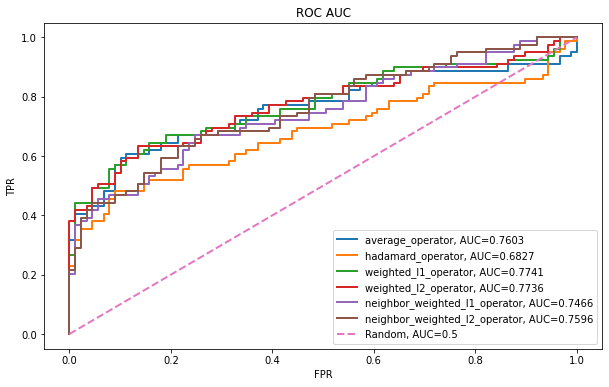

In [118]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()